In [1]:
import os
import numpy as np
import pickle
from matplotlib import pyplot as plt
from data_loader import PybulletNpyDataset, TabletopTemplateDataset

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34, resnet50

# Template-data

In [7]:
data_path = '/ssd/disk/TableTidyingUp/dataset_template/train'
#data_path = '/ssd/disk/TableTidyingUp/dataset_template/test-unseen_obj-seen_template'
#data_path = '/ssd/disk/TableTidyingUp/dataset_template/test-seen_obj-unseen_template'
#data_path = '/ssd/disk/TableTidyingUp/dataset_template/test-unseen_obj-unseen_template'
dataset = TabletopTemplateDataset(data_dir=data_path, 
            remove_bg=True, label_type='linspace', view='top')

skip /ssd/disk/TableTidyingUp/dataset_template/train/O9/template_00001/traj_00002 (4 steps)


In [8]:
len(dataset.data_paths)

96675

In [9]:
dataset.data_paths[0]

'/ssd/disk/TableTidyingUp/dataset_template/train/B3/template_00000/traj_00000/000'

In [4]:
dir(dataset)

['__add__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_is_protocol',
 'data_dir',
 'data_labels',
 'data_paths',
 'get_data_paths',
 'get_mask',
 'label_type',
 'remove_bg',
 'scene_index',
 'target_scene',
 'view']

In [3]:
resnet = resnet18
model_path = 'data/classification-best/top_nobg_linspace_mse-best.pth'
#data_path = '/ssd/disk/TableTidyingUp/dataset_template/train'
#data_path = '/ssd/disk/TableTidyingUp/dataset_template/test-unseen_obj-seen_template'
#data_path = '/ssd/disk/TableTidyingUp/dataset_template/test-seen_obj-unseen_template'
data_path = '/ssd/disk/TableTidyingUp/dataset_template/test-unseen_obj-unseen_template'
device = "cuda:0"

dataset = TabletopTemplateDataset(data_dir=data_path, 
            remove_bg=True, label_type='linspace', view='top')
dataset.fsize = 200
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=1)

model = resnet(pretrained=False)
fc_in_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(fc_in_features, 1),
    #nn.Sigmoid()
)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

/home/gun/anaconda3/envs/diffuser/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gun/anaconda3/envs/diffuser/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [94]:
resnet = resnet18
model_path = 'data/classification-best/top_nobg_linspace_mse-best.pth'
data_path = '/ssd/disk/TableTidyingUp/dataset_template/train'
#data_path = '/ssd/disk/TableTidyingUp/dataset_template/test-unseen_obj-seen_template'
#data_path = '/ssd/disk/TableTidyingUp/dataset_template/test-seen_obj-unseen_template'
#data_path = '/ssd/disk/TableTidyingUp/dataset_template/test-unseen_obj-unseen_template'
device = "cuda:0"

dataset = TabletopTemplateDataset(data_dir=data_path, 
            remove_bg=True, label_type='linspace', view='top')
dataset.fsize = 200
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=1)

skip /ssd/disk/TableTidyingUp/dataset_template/train/O9/template_00001/traj_00002 (4 steps)


In [5]:
def scoring(model, dataloader):
    scores = {}
    for s in [0, 0.25, 0.5, 0.75, 1]:
        scores[s] = []

    for X_val, Y_val in dataloader:
        x_raw = X_val.cpu().numpy().transpose([0, 2, 3, 1])
        X_val = preprocess(X_val).to(device)
        y_val = Y_val[:, 0].to(device)
        y_pred = model(X_val)[:, 0].detach().cpu().numpy()

        for s in [0, 0.25, 0.5, 0.75, 1]:
            scores[s] += y_pred[Y_val[:, 0]==s].tolist()
    return scores

In [95]:
scores = scoring(model, dataloader)

In [99]:
with open('data/score_train.pickle', 'wb') as f:
    pickle.dump(scores, f, pickle.HIGHEST_PROTOCOL)

In [38]:
scores.keys()

dict_keys([0, 0.25, 0.5, 0.75, 1])

In [6]:
for s in [0, 0.25, 0.5, 0.75, 1]:
    print(f'label: {s} / mean: {np.mean(scores[s])} / std: {np.std(scores[s])})')


label: 0 / mean: 0.2089111018246865 / std: 0.17449404720122255)
label: 0.25 / mean: 0.283584279886718 / std: 0.1856526061416466)
label: 0.5 / mean: 0.398526309090136 / std: 0.18835782131092674)
label: 0.75 / mean: 0.5705491407111853 / std: 0.15001914015593187)
label: 1 / mean: 0.8677036750618415 / std: 0.09836765247127696)


In [56]:
for s in [0, 0.25, 0.5, 0.75, 1]:
    print(f'label: {s} / mean: {np.mean(scores[s])} / std: {np.std(scores[s])})')


label: 0 / mean: 0.18068191948933182 / std: 0.1905025474167201)
label: 0.25 / mean: 0.2610891308262944 / std: 0.19648831393415275)
label: 0.5 / mean: 0.3832708420319322 / std: 0.19565771852611022)
label: 0.75 / mean: 0.5689518476896172 / std: 0.17330461138107386)
label: 1 / mean: 0.8983404783904553 / std: 0.10039306751081452)


In [6]:
scores_list = []
for fn in ['train', 'test_us', 'test_su', 'test_uu']:
    with open('data/score_%s.pickle'%fn, 'rb') as f:
        scores_list.append(pickle.load(f))

In [7]:
print(len(scores_list[1][0])*5)
print(len(scores_list[2][0])*5)
print(len(scores_list[3][0])*5)

40500
11850
9875


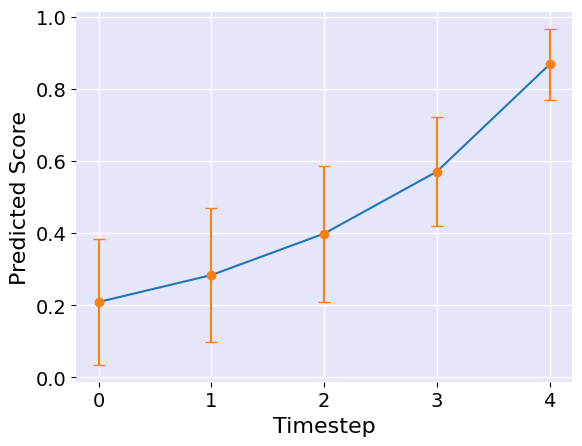

In [13]:
scores = scores_list[-1]
labels = np.array([0, 0.25, 0.5, 0.75, 1])
mean = [np.mean(scores[s]) for s in labels]
error = [np.std(scores[s]) for s in labels]
fig = plt.figure()
ax = fig.add_subplot()

ax.tick_params(axis='both', labelsize=14)
#ax.tick_params(axis='x', colors='white')
#ax.tick_params(axis='y', colors='white')
ax.patch.set_facecolor('lavender')
ax.grid(color = 'white', linestyle = '-', linewidth = 1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.plot(np.array(labels)*4, mean)
ax.errorbar(np.array(labels)*4, mean, error, fmt='o', capsize=4)
ax.set_xlabel("Timestep", fontsize=16)#, weight='bold')
ax.set_ylabel("Predicted Score", fontsize=16)#, weight='bold')
ax.set_xticks([0, 1, 2, 3, 4])
plt.show()


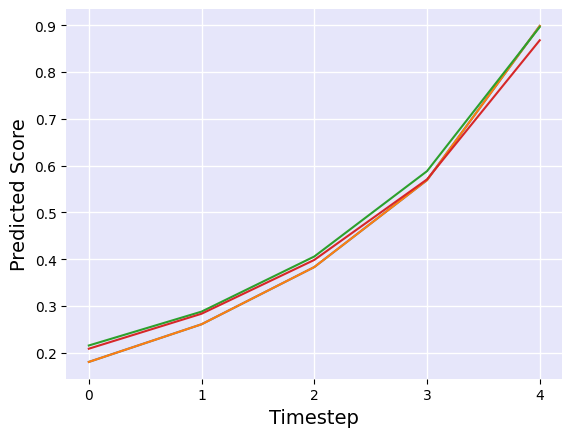

In [83]:
fig = plt.figure()
ax = fig.add_subplot()
#ax.tick_params(axis='x', colors='white')
#ax.tick_params(axis='y', colors='white')
ax.patch.set_facecolor('lavender')
ax.grid(color = 'white', linestyle = '-', linewidth = 1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

colors = ['pink', 'yellow', 'green','skyblue']
for i, scores in enumerate(scores_list):
    labels = np.array([0, 0.25, 0.5, 0.75, 1])
    mean = np.array([np.mean(scores[s]) for s in labels])
    error = np.array([np.std(scores[s]) for s in labels])

    ax.plot(np.array(labels)*4, mean)
    #ax.errorbar(np.array(labels)*4, mean, error, fmt='o', capsize=4)
    #ax.fill_between(np.array(labels)*4, mean+error, mean-error, facecolor=colors[i], alpha=0.5)

ax.set_xlabel("Timestep", fontsize=14)
ax.set_ylabel("Predicted Score", fontsize=14)
ax.set_xticks([0, 1, 2, 3, 4])
plt.show()


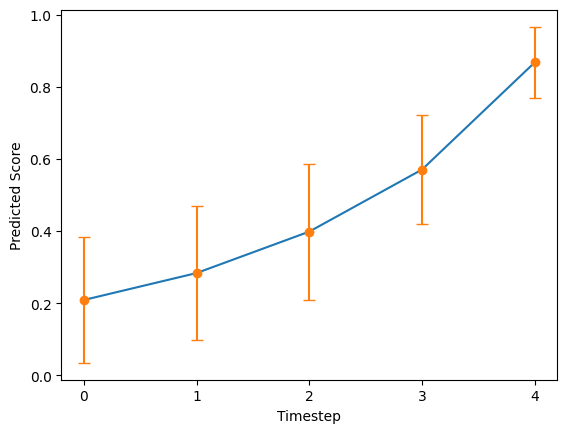

In [83]:
labels = np.array([0, 0.25, 0.5, 0.75, 1])
mean = [np.mean(scores[s]) for s in labels]
error = [np.std(scores[s]) for s in labels]

plt.plot(np.array(labels)*4, mean)
plt.errorbar(np.array(labels)*4, mean, error, fmt='o', capsize=4)
plt.xlabel("Timestep")
plt.ylabel("Predicted Score")
plt.xticks([0, 1, 2, 3, 4])
plt.show()


In [101]:
th = 0.85
for scores in scores_list:
    scores_all = np.concatenate([scores[s] for s in [0, 0.25, 0.5, 0.75, 1]])
    labels = np.concatenate([[s]*len(scores[s]) for s in [0, 0.25, 0.5, 0.75, 1]])

    recall = np.array(np.array(scores[1])>th).sum() / len(scores[1])
    precision = (labels[scores_all > th]==1).sum() / (scores_all > th).sum()
    f1score = 2 * (recall * precision) / (recall + precision)
    print('recall:', recall)
    print('precision:', precision)
    print('f1-score:', f1score)
    print()

recall: 0.9604344453064391
precision: 0.9051472021836615
f1-score: 0.9319715941883515

recall: 0.7286419753086419
precision: 0.9252233892459634
f1-score: 0.8152496719386698

recall: 0.7759493670886076
precision: 0.9162929745889388
f1-score: 0.840301576422207

recall: 0.610126582278481
precision: 0.9170471841704718
f1-score: 0.732745515354211



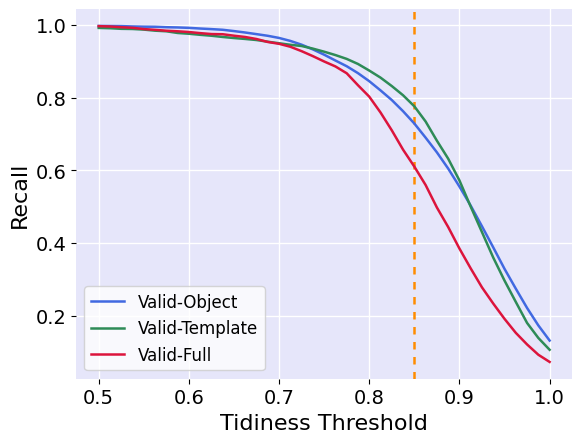

In [14]:
fig = plt.figure()
ax = fig.add_subplot()

#ax.tick_params(axis='x', colors='white')
#ax.tick_params(axis='y', colors='white')
ax.patch.set_facecolor('lavender')
ax.grid(color = 'white', linestyle = '-', linewidth = 1)
ax.tick_params(axis='both', labelsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axvline(0.85, 0, 1, color='darkorange', linestyle=(0, (3, 3)), linewidth=1.8)
#ax.axvline(0.85, 0, 1, color='blueviolet', linestyle=(0, (5, 5)), linewidth=1.0)

label_names = ['Valid-Object', 'Valid-Template', 'Valid-Full']

colors = ['royalblue', 'forestgreen', 'crimson']
colors = ['royalblue', 'seagreen', 'crimson']
# colors = ['darkcyan', 'darkorange', 'mediumvioletred']
#label_names = ['Train', 'Valid-Object', 'Valid-Template', 'Valid-Full']
for i, scores in enumerate(scores_list[1:]):
    scores_all = np.concatenate([scores[s] for s in [0, 0.25, 0.5, 0.75, 1]])
    labels = np.concatenate([[s]*len(scores[s]) for s in [0, 0.25, 0.5, 0.75, 1]])
    
    thresholds = np.linspace(0.5, 1, 41)
    recalls = []
    precisions = []
    f1scores = []

    for th in thresholds:
        recall = np.array(np.array(scores[1])>th).sum() / len(scores[1])
        recalls.append(recall)
        precision = (labels[scores_all > th]==1).sum() / (scores_all > th).sum()
        precisions.append(precision)
        f1score = 2 * (recall * precision) / (recall + precision)
        f1scores.append(f1score) 
    
    ax.plot(thresholds, recalls, color=colors[i], label=label_names[i], linewidth=1.8)
    ax.set_xlabel("Tidiness Threshold", fontsize=16)
    #ax.set_xlabel("Threshold of success", fontsize=14)
    ax.set_ylabel("Recall", fontsize=16)
    ax.legend(fontsize=12)
plt.show()

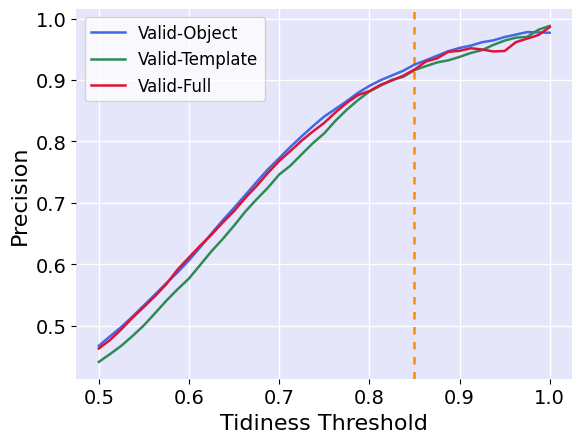

In [15]:
fig = plt.figure()
ax = fig.add_subplot()

#ax.tick_params(axis='x', colors='white')
#ax.tick_params(axis='y', colors='white')
ax.patch.set_facecolor('lavender')
ax.grid(color = 'white', linestyle = '-', linewidth = 1)
ax.tick_params(axis='both', labelsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axvline(0.85, 0, 1, color='darkorange', linestyle=(0, (3, 3)), linewidth=1.8)    

label_names = ['Valid-Object', 'Valid-Template', 'Valid-Full']
# label_names = ['Train', 'Valid-Object', 'Valid-Template', 'Valid-Full']

colors = ['royalblue', 'seagreen', 'crimson']
for i, scores in enumerate(scores_list[1:]):
    scores_all = np.concatenate([scores[s] for s in [0, 0.25, 0.5, 0.75, 1]])
    labels = np.concatenate([[s]*len(scores[s]) for s in [0, 0.25, 0.5, 0.75, 1]])
    
    thresholds = np.linspace(0.5, 1, 41)
    recalls = []
    precisions = []
    f1scores = []

    for th in thresholds:
        recall = np.array(np.array(scores[1])>th).sum() / len(scores[1])
        recalls.append(recall)
        precision = (labels[scores_all > th]==1).sum() / (scores_all > th).sum()
        precisions.append(precision)
        f1score = 2 * (recall * precision) / (recall + precision)
        f1scores.append(f1score) 

    ax.plot(thresholds, precisions, color=colors[i], label=label_names[i], linewidth=1.8)
    ax.set_xlabel("Tidiness Threshold", fontsize=16)
    ax.set_ylabel("Precision", fontsize=16)
    ax.legend(fontsize=12)
plt.show()

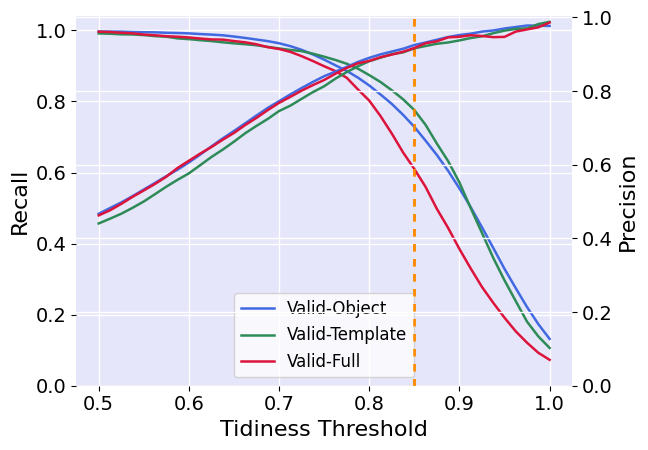

In [21]:
fig = plt.figure()
ax = fig.add_subplot()

#ax.tick_params(axis='x', colors='white')
#ax.tick_params(axis='y', colors='white')
ax.patch.set_facecolor('lavender')
ax.grid(color = 'white', linestyle = '-', linewidth = 1)
ax.tick_params(axis='both', labelsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axvline(0.85, 0, 1, color='darkorange', linestyle=(0, (3, 3)), linewidth=1.8)
#ax.axvline(0.85, 0, 1, color='blueviolet', linestyle=(0, (5, 5)), linewidth=1.0)

label_names = ['Valid-Object', 'Valid-Template', 'Valid-Full']

colors = ['royalblue', 'forestgreen', 'crimson']
colors = ['royalblue', 'seagreen', 'crimson']
# colors = ['darkcyan', 'darkorange', 'mediumvioletred']
#label_names = ['Train', 'Valid-Object', 'Valid-Template', 'Valid-Full']
for i, scores in enumerate(scores_list[1:]):
    scores_all = np.concatenate([scores[s] for s in [0, 0.25, 0.5, 0.75, 1]])
    labels = np.concatenate([[s]*len(scores[s]) for s in [0, 0.25, 0.5, 0.75, 1]])
    
    thresholds = np.linspace(0.5, 1, 41)
    recalls = []
    precisions = []
    f1scores = []

    for th in thresholds:
        recall = np.array(np.array(scores[1])>th).sum() / len(scores[1])
        recalls.append(recall)
        precision = (labels[scores_all > th]==1).sum() / (scores_all > th).sum()
        precisions.append(precision)
        f1score = 2 * (recall * precision) / (recall + precision)
        f1scores.append(f1score) 
    
    ax.plot(thresholds, recalls, color=colors[i], label=label_names[i], linewidth=1.8)
    ax.set_xlabel("Tidiness Threshold", fontsize=16)
    #ax.set_xlabel("Threshold of success", fontsize=14)
    ax.set_ylabel("Recall", fontsize=16)
    ax.set_ylim(0)
    ax.legend(loc=8, fontsize=12)
    
ax = ax.twinx()

#ax.tick_params(axis='x', colors='white')
#ax.tick_params(axis='y', colors='white')
ax.patch.set_facecolor('lavender')
ax.grid(color = 'white', linestyle = '-', linewidth = 1)
ax.tick_params(axis='both', labelsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axvline(0.85, 0, 1, color='darkorange', linestyle=(0, (3, 3)), linewidth=1.8)    

label_names = ['Valid-Object', 'Valid-Template', 'Valid-Full']
# label_names = ['Train', 'Valid-Object', 'Valid-Template', 'Valid-Full']

colors = ['royalblue', 'seagreen', 'crimson']
for i, scores in enumerate(scores_list[1:]):
    scores_all = np.concatenate([scores[s] for s in [0, 0.25, 0.5, 0.75, 1]])
    labels = np.concatenate([[s]*len(scores[s]) for s in [0, 0.25, 0.5, 0.75, 1]])
    
    thresholds = np.linspace(0.5, 1, 41)
    recalls = []
    precisions = []
    f1scores = []

    for th in thresholds:
        recall = np.array(np.array(scores[1])>th).sum() / len(scores[1])
        recalls.append(recall)
        precision = (labels[scores_all > th]==1).sum() / (scores_all > th).sum()
        precisions.append(precision)
        f1score = 2 * (recall * precision) / (recall + precision)
        f1scores.append(f1score) 

    ax.plot(thresholds, precisions, color=colors[i], label=label_names[i], linewidth=1.8)
    ax.set_xlabel("Tidiness Threshold", fontsize=16)
    ax.set_ylabel("Precision", fontsize=16)
    ax.set_ylim(0)
#     ax.legend(fontsize=12)

plt.show()

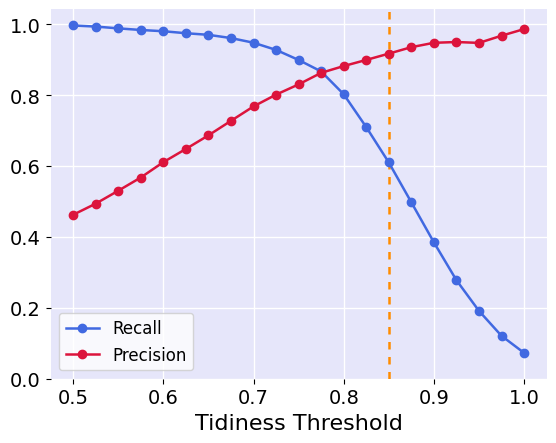

In [31]:
fig = plt.figure()
ax = fig.add_subplot()

#ax.tick_params(axis='x', colors='white')
#ax.tick_params(axis='y', colors='white')
ax.patch.set_facecolor('lavender')
ax.grid(color = 'white', linestyle = '-', linewidth = 1)
ax.tick_params(axis='both', labelsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axvline(0.85, 0, 1, color='darkorange', linestyle=(0, (3, 3)), linewidth=1.8)
#ax.axvline(0.85, 0, 1, color='blueviolet', linestyle=(0, (5, 5)), linewidth=1.0)

label_names = ['Valid-Object', 'Valid-Template', 'Valid-Full']

colors = ['royalblue', 'forestgreen', 'crimson']
colors = ['royalblue', 'seagreen', 'crimson']
# colors = ['darkcyan', 'darkorange', 'mediumvioletred']
#label_names = ['Train', 'Valid-Object', 'Valid-Template', 'Valid-Full']
for i, scores in enumerate(scores_list[3:]):
    scores_all = np.concatenate([scores[s] for s in [0, 0.25, 0.5, 0.75, 1]])
    labels = np.concatenate([[s]*len(scores[s]) for s in [0, 0.25, 0.5, 0.75, 1]])
    
    thresholds = np.linspace(0.5, 1, 21)
    recalls = []
    precisions = []
    f1scores = []

    for th in thresholds:
        recall = np.array(np.array(scores[1])>th).sum() / len(scores[1])
        recalls.append(recall)
        precision = (labels[scores_all > th]==1).sum() / (scores_all > th).sum()
        precisions.append(precision)
        f1score = 2 * (recall * precision) / (recall + precision)
        f1scores.append(f1score) 
    
    ax.plot(thresholds, recalls, 'o-', color='royalblue', label='Recall', linewidth=1.8)
    ax.plot(thresholds, precisions, 'o-', color='crimson', label='Precision', linewidth=1.8)
    ax.set_xlabel("Tidiness Threshold", fontsize=16)
    #ax.set_xlabel("Threshold of success", fontsize=14)
    #ax.set_ylabel("Recall", fontsize=16)
    ax.set_ylim(0)
    ax.legend(loc=3, fontsize=12)
    

plt.show()

In [84]:
th = 0.9
for scores in scores_list:
    scores_all = np.concatenate([scores[s] for s in [0, 0.25, 0.5, 0.75, 1]])
    labels = np.concatenate([[s]*len(scores[s]) for s in [0, 0.25, 0.5, 0.75, 1]])

    recall = np.array(np.array(scores[1])>th).sum() / len(scores[1])
    precision = (labels[scores_all > th]==1).sum() / (scores_all > th).sum()
    print('recall:', recall)
    print('precision:', precision)
    print()

recall: 0.5553086419753086
precision: 0.9523607876349778

recall: 0.5553086419753086
precision: 0.9523607876349778

recall: 0.5721518987341773
precision: 0.9377593360995851

recall: 0.3848101265822785
precision: 0.9476309226932669



In [26]:
scores_all = np.concatenate([scores[s] for s in [0, 0.25, 0.5, 0.75, 1]])
labels = np.concatenate([[s]*len(scores[s]) for s in [0, 0.25, 0.5, 0.75, 1]])

thresholds = np.linspace(0.5, 1, 21)
recalls = []
precisions = []

for th in thresholds:
    recall = np.array(scores[1]>th).sum() / len(scores[1])
    recalls.append(recall)
    precision = (labels[scores_all > th]==1).sum() / (scores_all > th).sum()
    precisions.append(precision)

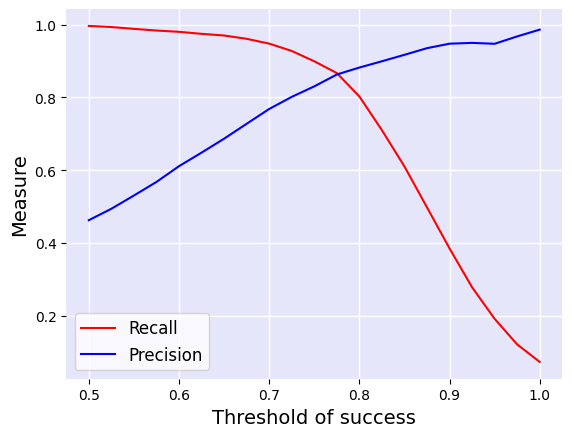

In [34]:
fig = plt.figure()
ax = fig.add_subplot()
#ax.tick_params(axis='x', colors='white')
#ax.tick_params(axis='y', colors='white')
ax.patch.set_facecolor('lavender')
ax.grid(color = 'white', linestyle = '-', linewidth = 1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.plot(thresholds, recalls, 'r-', label='Recall')
ax.plot(thresholds, precisions, 'b-', label='Precision')
ax.set_xlabel("Threshold of success", fontsize=14)
ax.set_ylabel("Measure", fontsize=14)
ax.legend(fontsize=12)
plt.show()

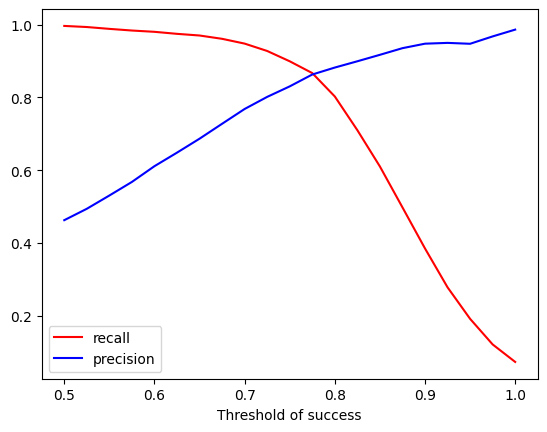

In [62]:
plt.plot(thresholds, recalls, 'r-', label='recall')
plt.plot(thresholds, precisions, 'b-', label='precision')
plt.xlabel("Threshold of success")
#plt.ylabel("Metrics")
plt.legend()
plt.show()

In [93]:
scores_all = np.concatenate([scores[s] for s in [0, 0.25, 0.5, 0.75, 1]])
labels = np.concatenate([[s]*len(scores[s]) for s in [0, 0.25, 0.5, 0.75, 1]])

for th in np.linspace(0.6, 1, 9):
    recall = np.array(scores[1]>th).sum() / len(scores[1])
    precision = (labels[scores_all > th]==1).sum() / (scores_all > th).sum()
    print(f'threshold: {th:.2f} / recall: {recall:.3f} / precision: {precision:.3f}')

threshold: 0.60 / recall: 0.980 / precision: 0.611
threshold: 0.65 / recall: 0.970 / precision: 0.686
threshold: 0.70 / recall: 0.948 / precision: 0.768
threshold: 0.75 / recall: 0.899 / precision: 0.830
threshold: 0.80 / recall: 0.803 / precision: 0.882
threshold: 0.85 / recall: 0.610 / precision: 0.917
threshold: 0.90 / recall: 0.385 / precision: 0.948
threshold: 0.95 / recall: 0.191 / precision: 0.947
threshold: 1.00 / recall: 0.073 / precision: 0.986
